In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import chi2
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE

Loading the agencies data and Initial data exploration

In [19]:
data = pd.read_csv('data/agencies.csv')

print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19166 entries, 0 to 19165
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ori               19166 non-null  object 
 1   county            19166 non-null  object 
 2   latitude          17219 non-null  float64
 3   longitude         17219 non-null  float64
 4   state_abbr        19166 non-null  object 
 5   state             19166 non-null  object 
 6   agency_name       19166 non-null  object 
 7   agency_type       17491 non-null  object 
 8   is_nibrs          19166 non-null  bool   
 9   nibrs_start_date  15105 non-null  object 
dtypes: bool(1), float64(2), object(7)
memory usage: 1.3+ MB
None
           latitude     longitude
count  17219.000000  17219.000000
mean      38.431584    -88.965840
std        4.785443     13.303851
min       -9.000000   -164.188912
25%       34.933239    -95.268743
50%       39.214480    -86.135794
75%       41.717780    

Now we will start data cleaning and handling missing values.

In [20]:
imputer = SimpleImputer(strategy='mean')
data['latitude'] = imputer.fit_transform(data[['latitude']])
data['longitude'] = imputer.fit_transform(data[['longitude']])
data['agency_type'].fillna(data['agency_type'].mode()[0], inplace=True)

C:\Users\smang\AppData\Local\Temp\ipykernel_21988\2016185274.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['agency_type'].fillna(data['agency_type'].mode()[0], inplace=True)


Standardizing categorical variables

In [21]:
data['state_abbr'] = data['state_abbr'].str.upper().str.strip()
data['county'] = data['county'].str.upper().str.strip()

Outlier Detection using Z-score

In [22]:
z_scores = np.abs(zscore(data[['latitude', 'longitude']]))
data = data[(z_scores < 3).all(axis=1)]

Exploratory Data Analysis (Geographical Distribution)

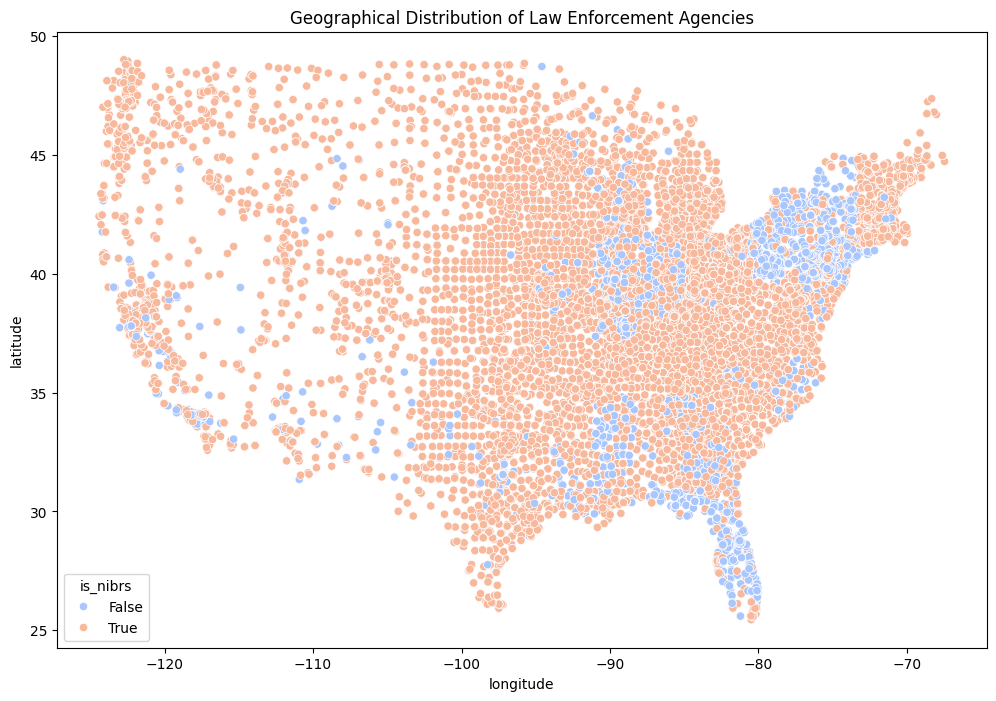

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='is_nibrs', data=data, palette='coolwarm')
plt.title('Geographical Distribution of Law Enforcement Agencies')
plt.show()

NIBRS Adoption Trends

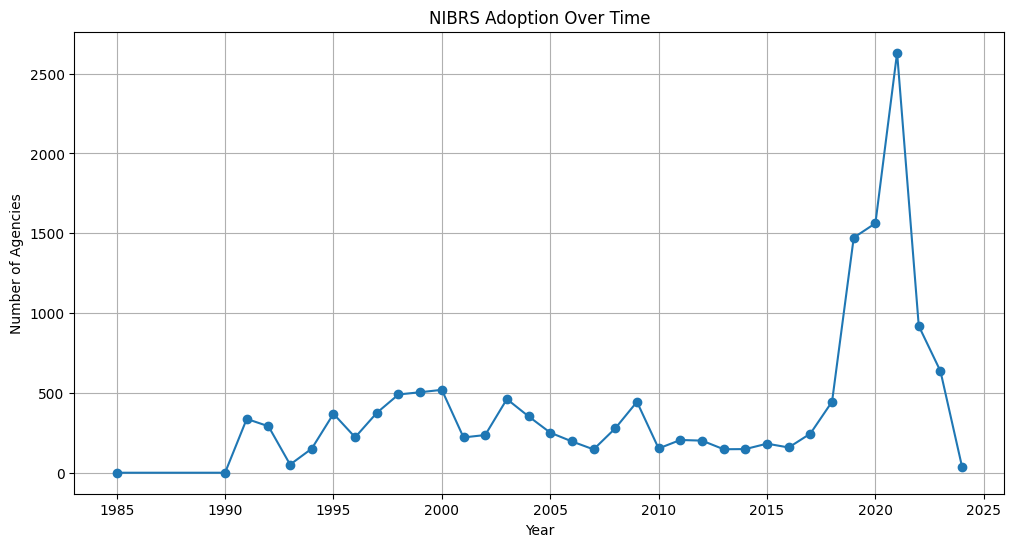

In [24]:
data['nibrs_start_year'] = pd.to_datetime(data['nibrs_start_date'], errors='coerce').dt.year
adoption_trends = data.groupby('nibrs_start_year').size()
plt.figure(figsize=(12, 6))
plt.plot(adoption_trends.index, adoption_trends.values, marker='o')
plt.title('NIBRS Adoption Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Agencies')
plt.grid(True)
plt.show()

Agency Density per County

In [25]:
density = data.groupby('county').size().to_dict()
data['agency_density_per_county'] = data['county'].map(density)

Encoding categorical variables

In [26]:
encoded_data = pd.get_dummies(data, columns=['state_abbr', 'agency_type', 'county'], drop_first=True)

Feature Selection

In [35]:
X = encoded_data.drop(columns=['is_nibrs', 'nibrs_start_date', 'nibrs_start_year', 'ori'])
y = encoded_data['is_nibrs']

Chi-square test for categorical variables

In [36]:
chi_scores = chi2(X, y)
chi2_scores_df = pd.Series(chi_scores[0], index=X.columns).sort_values(ascending=False)
print('Top 10 Features based on Chi-Square Test:\n', chi2_scores_df.head(10))

ValueError: could not convert string to float: 'Alabama'

Handling Class Imbalance using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
# Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

Model Evaluation

In [ ]:
models = {'Logistic Regression': log_reg, 'Decision Tree': decision_tree}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled if name == 'Logistic Regression' else X_test)
    print(f'--- {name} ---')
    print(classification_report(y_test, y_pred))
    print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Feature Importance from Decision Tree

In [ ]:
feature_importances = pd.Series(decision_tree.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.show()
